In [ ]:
!pip install opencv-python matplotlib scikit-learn pillow

In [2]:
#Check if there is a GPU Available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
!pip list

# IMPORT DEPENDENCIES

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image  # Import Image module from Pillow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# # Specify the path to your dataset
# train_dir = 'path_to_your_training_data_directory'
# validation_dir = 'path_to_your_validation_data_directory'

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# LOAD DATA (SPLIT DATA)

In [9]:
original_dataset_path = 'data'

# Specify the path for the new train, validation, and test directories
base_dir = 'DATASET'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [5]:
# List all subdirectories (categories) in the original dataset
categories = [category for category in os.listdir(original_dataset_path) if not category.startswith('.')]  # Exclude hidden directories

# Specify the ratios for splitting (e.g., 45% training, 45% validation, 10% test)
train_ratio = 0.60
validation_ratio = 0.30
test_ratio = 0.10

# Iterate through each category and split the images
for category in categories:
    category_path = os.path.join(original_dataset_path, category)
    images = [image for image in os.listdir(category_path) if not image.startswith('.')]  # Exclude hidden files

    # Split the images into training, validation, and test sets
    train_images, test_images = train_test_split(images, test_size=test_ratio, random_state=42)
    remaining_images = list(set(images) - set(test_images))
    train_images, validation_images = train_test_split(remaining_images, test_size=validation_ratio / (train_ratio + validation_ratio), random_state=42)

    # Create subdirectories in the new train, validation, and test directories
    train_category_dir = os.path.join(train_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)

    validation_category_dir = os.path.join(validation_dir, category)
    os.makedirs(validation_category_dir, exist_ok=True)

    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(test_category_dir, exist_ok=True)

    # Copy images to the new directories
    for image_name in train_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(train_category_dir, image_name)
        shutil.copyfile(source_path, destination_path)

    for image_name in validation_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(validation_category_dir, image_name)
        shutil.copyfile(source_path, destination_path)

    for image_name in test_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(test_category_dir, image_name)
        shutil.copyfile(source_path, destination_path)

print("Data splitting completed.")

Data splitting completed.


# PREROCESS DATA + AUGMENTATION

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)



Found 4200 images belonging to 3 classes.
Found 3820 images belonging to 3 classes.


# MODEL BUILDING AND TRAINING (Don't Run if your not gonna train, proceed to TESTING)

In [9]:
# Use VGG16 as a base model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation='softmax')
])

58889256/58889256 [==============================] - 5s 0us/step


In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,  # Experiment with the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)


Epoch 1/30
132/132 [==============================] - 138s 938ms/step - loss: 1.1096 - accuracy: 0.9464 - val_loss: 0.0405 - val_accuracy: 0.9887
Epoch 2/30
132/132 [==============================] - 107s 809ms/step - loss: 0.1084 - accuracy: 0.9695 - val_loss: 0.0477 - val_accuracy: 0.9793
Epoch 3/30
132/132 [==============================] - 126s 957ms/step - loss: 0.0895 - accuracy: 0.9728 - val_loss: 0.0403 - val_accuracy: 0.9809
Epoch 4/30
132/132 [==============================] - 111s 844ms/step - loss: 0.0748 - accuracy: 0.9733 - val_loss: 0.0371 - val_accuracy: 0.9840
Epoch 5/30
132/132 [==============================] - 113s 858ms/step - loss: 0.0800 - accuracy: 0.9733 - val_loss: 0.0339 - val_accuracy: 0.9880
Epoch 6/30
132/132 [==============================] - 116s 882ms/step - loss: 0.0774 - accuracy: 0.9724 - val_loss: 0.0439 - val_accuracy: 0.9874
Epoch 7/30
132/132 [==============================] - 115s 870ms/step - loss: 0.0669 - accuracy: 0.9733 - val_loss: 0.0355 -

In [14]:
# Save the model
model.save('image_classifier_model_eye_cataract_conjunc.h5')

# PERFORMANCE AND ACCURACY PLOT

In [15]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print('\nTest accuracy:', test_acc)

120/120 - 36s - loss: 0.0329 - accuracy: 0.9872 - 36s/epoch - 301ms/step

Test accuracy: 0.9871727824211121


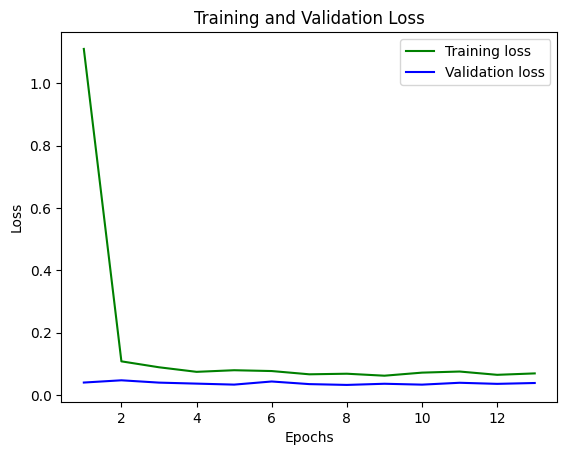

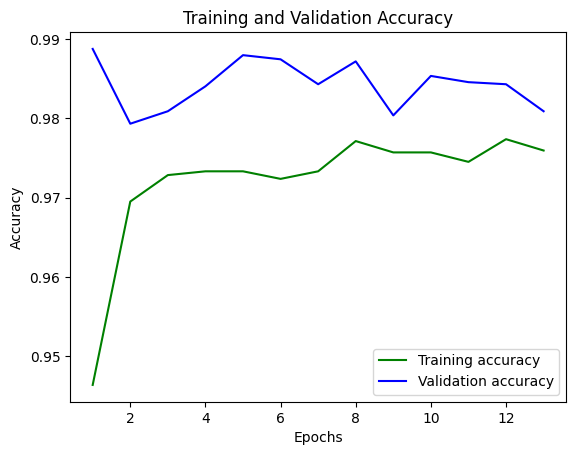

In [16]:
# Plot the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# TEST MODEL

Class labels: ['Cataract', 'Conjunctivitis', 'Normal']
1/1 [==============================] - 0s 240ms/step
The predicted class is: Normal


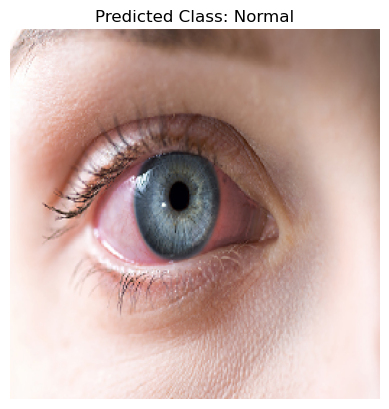

In [45]:
# Load the saved model
loaded_model = tf.keras.models.load_model('image_classifier_model_eye_cataract_conjunc.h5')

# Print the class labels
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

# Preprocess a test image and make predictions
test_image_path = "DATASET/validation/Conjunctivitis/infected-eye_9.jpg"
img = image.load_img(test_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the image
prediction = loaded_model.predict(img_array)

# Print the predicted class
predicted_class = np.argmax(prediction, axis=-1)
predicted_label = class_labels[predicted_class[0]]
print("The predicted class is:", predicted_label)

# Visualize the test image and predicted class
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()